In [7]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from python_speech_features import mfcc
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

import audio_class
import vad_nn

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fs,dataSet,tMarks,nMarks,fSpec,fLab,tBlk,tInc = audio_class.prepareDataset()
print(dataSet.shape)
print(tMarks.shape)
print(nMarks.shape)

load raw audio
tElapsed = 48.485782
extract spectrogram
rounded tBlk = 0.021
rounded tInc = 0.011
tElapsed = 14.794125000000001
form frame labels
tElapsed = 0.001803000000009547
(66847354,)
(206, 2)
(206, 2)


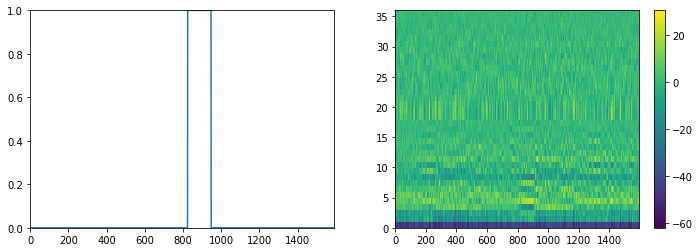

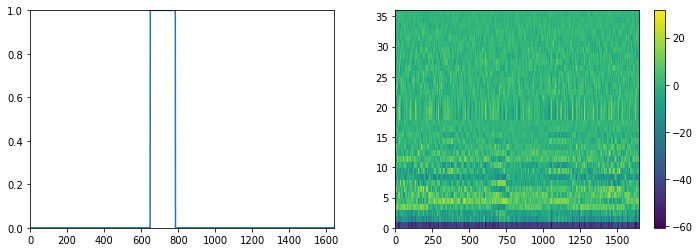

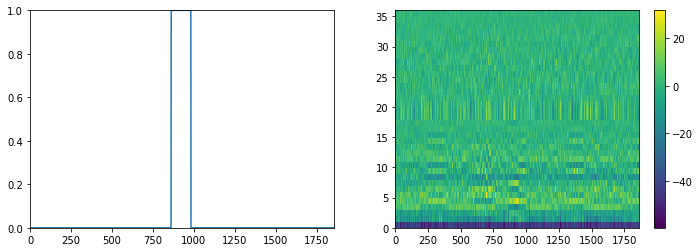

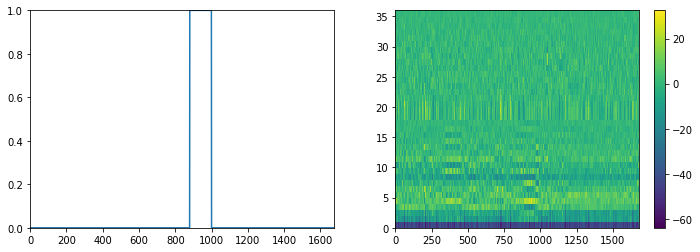

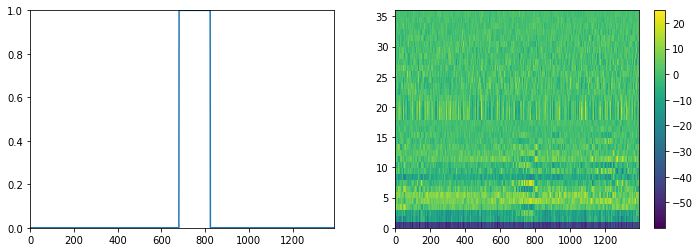

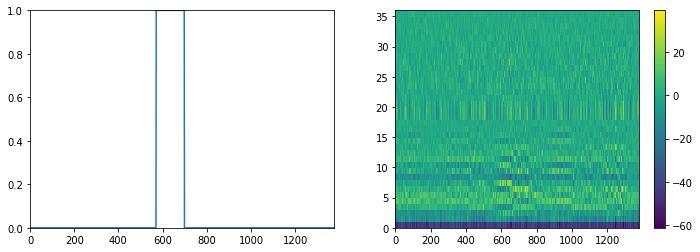

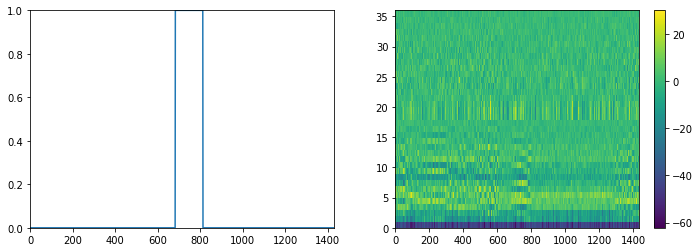

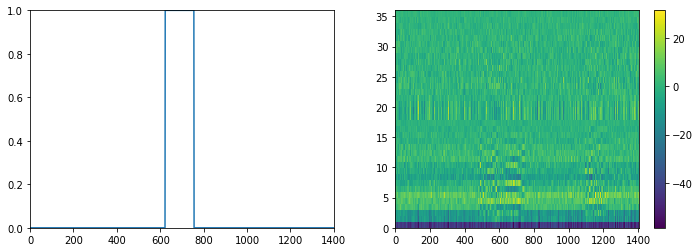

In [3]:
# extract mfcc features
target = []
feat = []
for k in range(103,111):
    # extract MFCC features
    # include before and after noise
    data = dataSet[int(tMarks[k-1,1]*fs):int(tMarks[k+1,0]*fs)]
    mfcc_feat = mfcc(data,fs,winlen=0.025,winstep=0.01,numcep=19,nfilt=26,nfft=1024) # frame x feat
    #print('mfcc_feat.shape',mfcc_feat.shape)
    mfcc_feat = np.delete(mfcc_feat,0,axis=1) # remove the 0-th coef
    mfcc_delta_feat = np.diff(mfcc_feat,axis=0)
    #print('mfcc_delta_feat.shape',mfcc_delta_feat.shape)
    feat.append(np.concatenate((mfcc_feat[:-1,:],mfcc_delta_feat),axis=1))
    
    # form labels
    numFrames = len(mfcc_delta_feat)
    label = np.zeros((numFrames,1))
    for n in range(numFrames):
        t = n*0.01+tMarks[k-1,1] # time (s) of the current frame
        if t >= tMarks[k,0] and t < tMarks[k,1]:
            label[n] = 1.
    target.append(label)
    
    # plots
    fig = plt.figure(figsize=(12,4))
    plt.subplot(121)
    t = np.arange(tMarks[k-1,1],tMarks[k+1,0],(tMarks[k+1,0]-tMarks[k-1,1])/len(data))
    #plt.plot(t,data)
    plt.plot(label)
    plt.autoscale(True,'both',True)
    ax = plt.subplot(122)
    im = plt.pcolormesh(feat[-1].T)
    plt.autoscale(True,'both',True)
    fig.colorbar(im,ax=ax)

In [4]:
# truncate to get the same seq-length batch
lens = [len(x) for x in feat]
print('lens',lens)
len_min = np.min(lens)
feat_trun = [x[:len_min,:] for x in feat]
target_trun = [x[:len_min,:] for x in target]

# stack along batch, inserted as dim 0
# batch, seq, feat
feat_trun = np.stack(feat_trun,axis=0)
target_trun = np.stack(target_trun,axis=0)
print('feat_trun.shape',feat_trun.shape)
print('target_trun.shape',target_trun.shape)

lens [1594, 1644, 1860, 1678, 1392, 1379, 1432, 1404]
feat_trun.shape (8, 1379, 36)
target_trun.shape (8, 1379, 1)


In [ ]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

if torch.cuda.is_available():
    print('run on GPU')
    dtype = torch.cuda.FloatTensor
else:
    print('run on CPU')
    dtype = torch.FloatTensor

# load data and make training set
feat_train_va = Variable(torch.from_numpy(feat_trun[:6,:,:]).type(dtype), requires_grad=False)
target_train_va = Variable(torch.from_numpy(target_trun[:6,:,:]).type(dtype), requires_grad=False)
feat_test_va = Variable(torch.from_numpy(feat_trun[6:,:,:]).type(dtype), requires_grad=False)
target_test_va = Variable(torch.from_numpy(target_trun[6:,:,:]).type(dtype), requires_grad=False)

# build the model
vad_lstm = vad_nn.VAD_LSTM().type(dtype)
#vad_lstm.load_state_dict(torch.load('log/vad_lstm_10000.pt'))
criterion = nn.MSELoss()
optimizer = optim.SGD(vad_lstm.parameters(),lr=1e-5,momentum=0.9)

#begin to train
loss_train = []
loss_test = []
startEpoch = 0
numEpochs = 40
for i in range(startEpoch,startEpoch+numEpochs):
    print('EPOCH: %d' % i)
    
    # forward pass
    out_va,_,_ = vad_lstm(feat_train_va)
    
    # evaluate the train loss
    loss = criterion(out_va, target_train_va)
    loss_train.append(loss.data[0])

    # zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # evaluate the test loss 
    out_va,_,_ = vad_lstm(feat_test_va)
    loss = criterion(out_va, target_test_va)
    loss_test.append(loss.data[0])
    
    # save intermediate models
    if i % 200 == 0 or i == startEpoch+numEpochs-1:
        torch.save(vad_lstm.state_dict(),'log/vad_lstm_%d.pt' % i)
                                                                                                                                                    
loss_train = np.array(loss_train)
loss_test = np.array(loss_test)

In [9]:
# save important vars
os.system('cp log/vad_lstm_39.pt log/vad_lstm.pt')
with open('log/loss_train_test.pkl','wb') as fid:
    pickle.dump((loss_train,loss_test),fid)

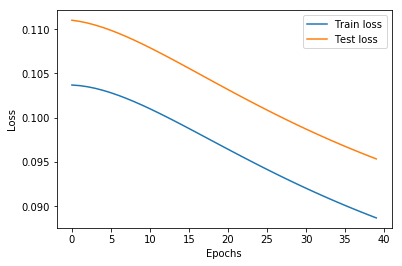

In [10]:
# plot losses
with open('log/loss_train_test.pkl','rb') as fid:
    loss_train,loss_test = pickle.load(fid)

plt.figure()
plt.plot(loss_train,label='Train loss')
plt.plot(loss_test,label='Test loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

feat_train_va.data.size() torch.Size([6, 1379, 36])
out_va.data.size() torch.Size([6, 1379, 1])
out.shape (6, 1379, 1)


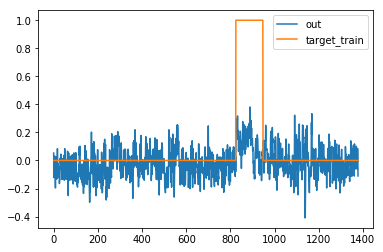

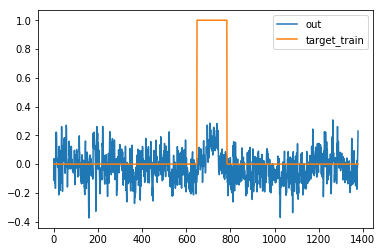

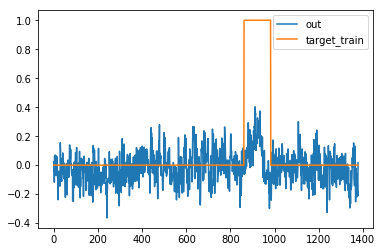

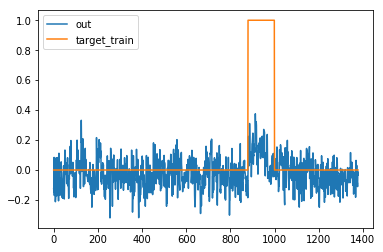

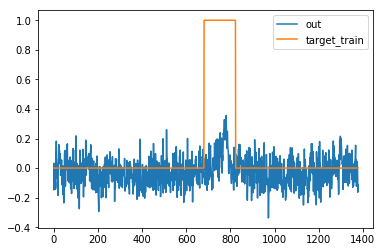

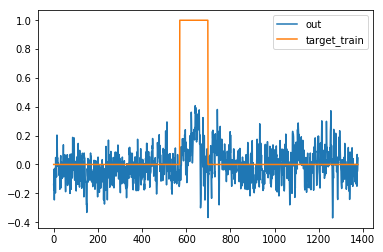

In [11]:
# visualize results
vad_lstm = vad_nn.VAD_LSTM().type(dtype)
vad_lstm.load_state_dict(torch.load('log/vad_lstm.pt'))

print('feat_train_va.data.size()',feat_train_va.data.size())
out_va,_,_ = vad_lstm(feat_train_va)
print('out_va.data.size()',out_va.data.size())
out = out_va.data.cpu().numpy()
print('out.shape',out.shape)
target_train = target_train_va.data.cpu().numpy()

for j in range(len(target_train)):
    plt.figure(figsize=(6,4))
    plt.plot(out[j,:],label='out')
    plt.plot(target_train[j,:],label='target_train')
    plt.legend()